In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%pylab inline

from datetime import datetime,timedelta
import re

import time

from scipy import stats

import seaborn as sns

# import sys
# reload(sys)
# sys.setdefaultencoding('utf-8')

Populating the interactive namespace from numpy and matplotlib


In [2]:
data = pd.read_csv('imbalanced_merged.csv')

In [3]:
data.columns

Index([u'Unnamed: 0', u'advertiser_app_store_id', u'country_code', u'city',
       u'campaign_id', u'creative_id', u'device_language', u'device_make',
       u'device_model', u'device_platform', u'device_connection',
       u'device_os_version', u'device_screen_height', u'device_screen_width',
       u'device_volume', u'event_id', u'n_campaign_views',
       u'n_vungle_installs', u'publisher_app_store_id',
       u'time_of_last_delivery_this_campaign',
       u'time_of_last_delivery_this_creative',
       u'time_of_last_delivery_any_installed_app',
       u'time_of_last_vungle_delivery', u'time_of_this_impression',
       u'timestamp_at_install', u'time_of_this_request', u'time_zone',
       u'is_install', u'market_id', u'is_publisher', u'platform', u'title',
       u'created_at', u'last_updated_at', u'version', u'size', u'developer',
       u'developer_website', u'market_url', u'languages', u'content_rating',
       u'genre_ids', u'genres', u'current_version_user_ratings',
       u'n_

## Clean Data

### combine duplicate level of content_rating

In [ ]:
data['content_rating'][data['content_rating'] == 'Mature 17+'] = '17+'
data['content_rating'][data['content_rating'] == 'Teen'] = '12+'
data['content_rating'][data['content_rating'] == 'Everyone 10+'] = '10+'

### group user_rating to categorical variable

In [ ]:
data['user_rating_round'] = data['user_rating'].apply(lambda x: str(round(x)))

### Convert timestamps to weekdat format

In [ ]:
cols = ['time_of_last_delivery_this_campaign', 'time_of_last_delivery_this_creative', 'time_of_last_delivery_any_installed_app',
       'time_of_last_delivery_any_installed_app','time_of_last_vungle_delivery', 'time_of_this_impression','time_of_this_request']
for col in cols:
    print col
    name = col + "_date"
    data[name] = data[col].apply(lambda x: str(pd.to_datetime(x).weekday()))

### get region from time zone

In [ ]:
def get_region(x):
    if len(str(x).split('/')) > 1:
        return str(x).split('/')[0]
    else:
        return None
    
data_install['time_zone_region'] = data_install['time_zone'].apply(lambda x: get_region(x))

In [ ]:
data[data['time_zone_continent'] == 'Indian'] = 'Asia'
data_install[data_install['time_zone_continent'] == 'Indian']['time_zone_continent'] = 'Asia'

### standardize the format of device_language

In [ ]:
data['device_language'] = data['device_language'].apply(lambda x: str(x).lower().split('-')[0])

## Grouping insignificant levels

In [ ]:
def new_col_sig98(df, col):
    sig_level = 0.02
    df = df.copy()
    items = df[col].unique()
    for i in items:
        a = df[df[col] == i]['is_install']
        b = df[df[col] != i]['is_install']
        t, p = stats.ttest_ind(a, b, equal_var=False)
        if p >= sig_level:
            df[col][df[col] == i] = 'other'
    return df[col]

In [ ]:
cols = ['advertiser_app_store_id', 'country_code', 'device_language', 'device_platform',
       'device_connection', 'time_zone_region', 'is_publisher', 'title', 'developer',
        'content_rating', 'current_version_user_ratings', 'user_rating_round', 
        'screenshot_urls', 'package_name', 'primary_category', 
        'has_in_app_purchases']
for col in cols:
    print col
    name = col + '_98'
    data[name] = new_col_sig98(data, col)

### EDA

In [48]:
temp_data = data[['is_install', u'is_publisher', u'title', u'developer',
       u'content_rating', u'current_version_user_ratings', u'user_rating', u'screenshot_urls', 
       u'package_name', u'website', u'primary_category', u'has_in_app_purchases']]

In [43]:
temp_data.ix[0,:]

is_install                                                                      0
is_publisher                                                                    f
title                                                Heart of Vegas™ Slots Casino
developer                                                         Product Madness
content_rating                                                               Teen
current_version_user_ratings                                                  NaN
user_rating                                                               4.38363
min_os_version                                                                NaN
supported_devices                                                             NaN
screenshot_urls                 ["https://lh3.googleusercontent.com/fegHg6GLGc...
package_name                                         com.productmadness.hovmobile
website                                             http://www.productmadness.com
primary_category

#### check how many levels in each feature

In [44]:
for col in temp_data.columns:
    if type(temp_data[col][0]) != list:
        print col, ":", len(temp_data[col].unique())

is_install : 2
is_publisher : 2
title : 2322
developer : 1437
content_rating : 10
current_version_user_ratings : 10
user_rating : 1864
min_os_version : 19
supported_devices : 8
screenshot_urls : 2497
package_name : 1901
website : 1163
primary_category : 41
has_in_app_purchases : 3


In [ ]:
# def str2list(x):
#     if x == 'nan':
#         return None
#     else:
#         return eval(x)
    
# temp_data['languages'] = temp_data['languages'].apply(lambda x: str2list(str(x)))
# temp_data['genres'] = temp_data['genres'].apply(lambda x: str2list(str(x)))
# temp_data['languages_publisher'] = temp_data['languages_publisher'].apply(lambda x: str2list(str(x)))

# temp_data_im['languages'] = temp_data_im['languages'].apply(lambda x: str2list(str(x)))
# temp_data_im['genres'] = temp_data_im['genres'].apply(lambda x: str2list(str(x)))
# temp_data_im['languages_publisher'] = temp_data_im['languages_publisher'].apply(lambda x: str2list(str(x)))

In [7]:
def percent_df(df, col1, col2):
    counts = pd.crosstab(df[col1], df[col2])
    return counts.div(counts.sum(1).astype(float), axis=0)

def percent_plot(percent_df):
    plt.figure(figsize=(800,1000))
    ax = percent_df.plot(kind='barh',stacked=True, alpha=0.8, figsize=(8,6))
    ax.set_xlabel("Percentage", fontsize=12)
    ax.set_ylabel("Is Install", fontsize=12)
    ax.legend(loc=0, prop={'size':7})
    plt.show()

In [8]:
data_install = temp_data[temp_data['is_install'] == 1]
data_install

,is_install,is_publisher,title,last_updated_at,size,developer,content_rating,current_version_user_ratings,n_current_version_user_ratings,user_rating,min_os_version,supported_devices,screenshot_urls,package_name,website,primary_category,has_in_app_purchases
2,1,f,Word Cookies!,2017-01-03 22:59:54,90319872.0,BitMango Corporation,4+,4.5,9414.0,4.500000,6.0,"[""iPhone-3GS"",""iPhone4"",""iPodTouchFourthGen"",""...","[""http://a5.mzstatic.com/us/r30/Purple111/v4/1...",NaN,NaN,NaN,NaN
5,1,f,Ông trùm Poker - Game danh bai,2017-01-12 00:00:00,NaN,Gamesofa Global Limited,Teen,NaN,NaN,4.593970,NaN,NaN,"[""https://lh3.googleusercontent.com/MP5AtkkXwi...",com.gamesofa.android.ongtrumpoker,http://www.gamesofa.com,GAME_CASINO,t
13,1,f,Word Cookies,2017-01-09 00:00:00,NaN,BitMango,Everyone,NaN,NaN,4.545188,NaN,NaN,"[""https://lh3.googleusercontent.com/J4bkKaOvNh...",com.bitmango.go.wordcookies,https://www.facebook.com/bitmangogames,GAME_WORD,t
18,1,f,Colorfy: Coloring Book for Adults - Free,2017-01-12 13:34:45,101764096.0,Fun Games For Free,4+,4.5,4279.0,5.000000,8.0,"[""iPad2Wifi"",""iPad23G"",""iPhone4S"",""iPadThirdGe...","[""http://a1.mzstatic.com/us/r30/Purple122/v4/0...",NaN,NaN,NaN,NaN
21,1,f,Fruits Mania : Elly’s travel,2017-02-01 00:00:00,NaN,BitMango,Everyone,NaN,NaN,4.514041,NaN,NaN,"[""https://lh3.googleusercontent.com/fv7NpHW339...",com.bitmango.go.fruitsmaniamatch3,https://www.facebook.com/bitmangogames,GAME_PUZZLE,t
24,1,f,Township,2017-01-30 08:29:52,183151616.0,PLR Worldwide Sales Limited,4+,4.5,661.0,4.500000,7.0,"[""iPhone4"",""iPad2Wifi"",""iPad23G"",""iPhone4S"",""i...","[""http://a5.mzstatic.com/us/r30/Purple71/v4/d5...",NaN,NaN,NaN,NaN
25,1,f,Angry Birds 2,2016-12-21 00:00:00,NaN,Rovio Entertainment Ltd.,Everyone,NaN,NaN,4.486835,NaN,NaN,"[""https://lh3.googleusercontent.com/sbm_SGCsAX...",com.rovio.baba,http://www.rovio.com,GAME_CASUAL,t
27,1,f,Word Cookies!,2017-01-03 22:59:54,90319872.0,BitMango Corporation,4+,4.5,9414.0,4.500000,6.0,"[""iPhone-3GS"",""iPhone4"",""iPodTouchFourthGen"",""...","[""http://a5.mzstatic.com/us/r30/Purple111/v4/1...",NaN,NaN,NaN,NaN
37,1,f,Toy Blast,2017-01-28 15:36:45,257485824.0,Peak Games,4+,4.5,976.0,4.500000,7.0,"[""iPhone4"",""iPad2Wifi"",""iPad23G"",""iPhone4S"",""i...","[""http://a3.mzstatic.com/us/r30/Purple62/v4/fe...",NaN,NaN,NaN,NaN
42,1,f,Fleet Command-Legion Wars,2016-09-27 00:00:00,NaN,Movga Games,Everyone 10+,NaN,NaN,3.686553,NaN,NaN,"[""https://lh3.googleusercontent.com/cvf5RcyknO...",com.movga.fleetcommand.gp,http://www.movga.com,GAME_STRATEGY,t


In [12]:
def get_conversion_table(col):
    ins = pd.DataFrame(data_install.groupby(col)['is_install'].count().rename('install_counts')).reset_index()
    total = pd.DataFrame(temp_data.groupby(col)['is_install'].count().rename('total_counts')).reset_index()
    counts_ad = total.merge(ins, how = 'left', on = col).fillna(0.0)
    counts_ad['conversion'] = counts_ad['install_counts']/counts_ad['total_counts']
    return counts_ad.sort_values('conversion', ascending = False)

def plot_coversion(df, col):
    plt.figure(figsize=(10, 8))
    df[['conversion']].plot(kind='barh',stacked=True, alpha=0.8)
    plt.xlabel("Conversion", fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.yticks(range(len(df[col].unique())), df[col], fontsize=10)
    plt.legend(loc=0,prop={'size':12})
    plt.show()

### is_publisher

In [13]:
counts_pb = get_conversion_table('is_publisher')
counts_pb

,is_publisher,total_counts,install_counts,conversion
0,f,699425,134951,0.192946
1,t,575,98,0.170435


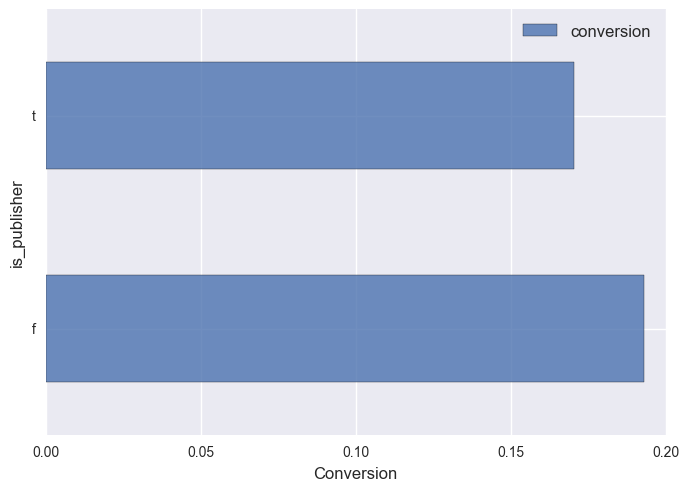

In [14]:
plot_coversion(counts_pb,'is_publisher')

### tittle

In [21]:
counts_t = get_conversion_table('title')
counts_t.iloc[470:500,:]

,title,total_counts,install_counts,conversion
1473,Road Riot,9,2.0,0.222222
1037,Lollipop Crush,278,61.0,0.219424
458,Cut the Rope 2,32,7.0,0.218750
215,Bubble Cloud - Spinning Bubble Shooter,1117,243.0,0.217547
257,COOKING MAMA Let's Cook！,23,5.0,0.217391
1293,Pearl's Peril,578,125.0,0.216263
222,Bubble Island 2 - Pop Bubble Shooter,370,80.0,0.216216
919,Invasion: Modern Empire,4204,908.0,0.215985
572,Dungeon Boss,2029,438.0,0.215870
1897,Two Dots,432,93.0,0.215278


### developer

In [27]:
counts_dev = get_conversion_table('developer')
counts_dev.iloc[200:250,:]

,developer,total_counts,install_counts,conversion
566,Ibotta,535,157.0,0.293458
631,Kabam Inc.,5862,1717.0,0.292903
1009,Rovio Entertainment Ltd.,5741,1679.0,0.292458
1082,Smule,11669,3395.0,0.290942
249,Crowdstar Inc,111,32.0,0.288288
720,MIR Partners Inc.,59,17.0,0.288136
762,Mino Games,7,2.0,0.285714
1249,WRKSHP,419,118.0,0.281623
202,Cervo Media GmbH,25,7.0,0.280000
107,BANDAI NAMCO Entertainment Europe,137,38.0,0.277372


### content_rating

In [28]:
temp_data['content_rating'][temp_data['content_rating'] == 'Mature 17+'] = '17+'
temp_data['content_rating'][temp_data['content_rating'] == 'Teen'] = '12+'
temp_data['content_rating'][temp_data['content_rating'] == 'Everyone 10+'] = '10+'

/Users/amiee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/amiee/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/amiee/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns

In [29]:
counts_cr = get_conversion_table('content_rating')
counts_cr

,content_rating,total_counts,install_counts,conversion
3,4+,154446,39392.0,0.255054
5,Everyone,242321,48876.0,0.201699
4,9+,30748,3953.0,0.128561
2,17+,34762,2907.0,0.083626
1,12+,186405,14257.0,0.076484
6,Unrated,15,1.0,0.066667
0,10+,36702,0.0,0.000000


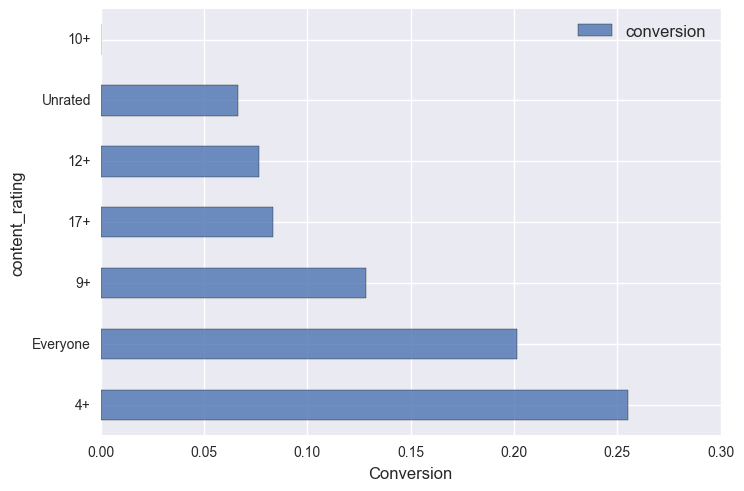

In [30]:
plot_coversion(counts_cr, 'content_rating')

### current_version_user_ratings

In [31]:
counts_cur = get_conversion_table('current_version_user_ratings')
counts_cur

,current_version_user_ratings,total_counts,install_counts,conversion
7,4.5,200610,47331.0,0.235935
0,1.0,459,103.0,0.224401
5,3.5,3310,698.0,0.210876
8,5.0,17911,3598.0,0.200882
3,2.5,2464,486.0,0.197240
6,4.0,45473,7942.0,0.174653
2,2.0,460,73.0,0.158696
4,3.0,3003,291.0,0.096903
1,1.5,5,0.0,0.000000


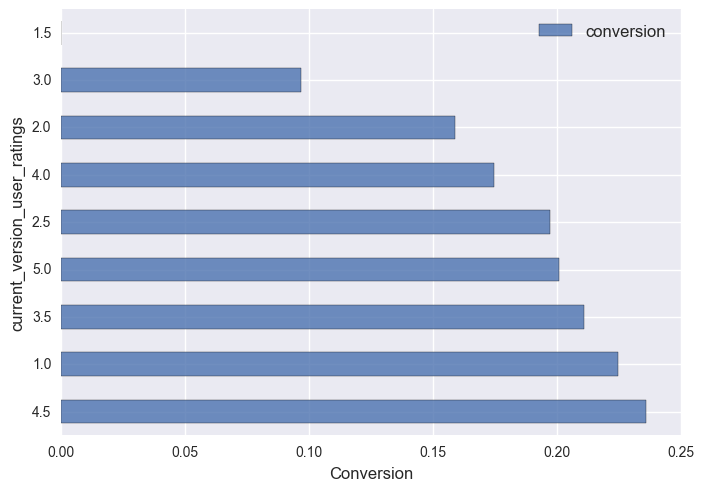

In [32]:
plot_coversion(counts_cur, 'current_version_user_ratings')

### user_rating

In [85]:
data['user_rating_round'] = data['user_rating'].apply(lambda x: round(x))

In [36]:
temp_data['user_rating_round'] = temp_data['user_rating'].apply(lambda x: round(x))
data_install['user_rating_round'] = data_install['user_rating'].apply(lambda x: round(x))
counts_ur = get_conversion_table('user_rating_round')
counts_ur

/Users/amiee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,user_rating_round,total_counts,install_counts,conversion
2,2.0,7,2.0,0.285714
5,5.0,374049,90570.0,0.242134
0,0.0,7978,1115.0,0.139759
4,4.0,300211,40677.0,0.135495
3,3.0,2625,250.0,0.095238
1,1.0,1,0.0,0.000000


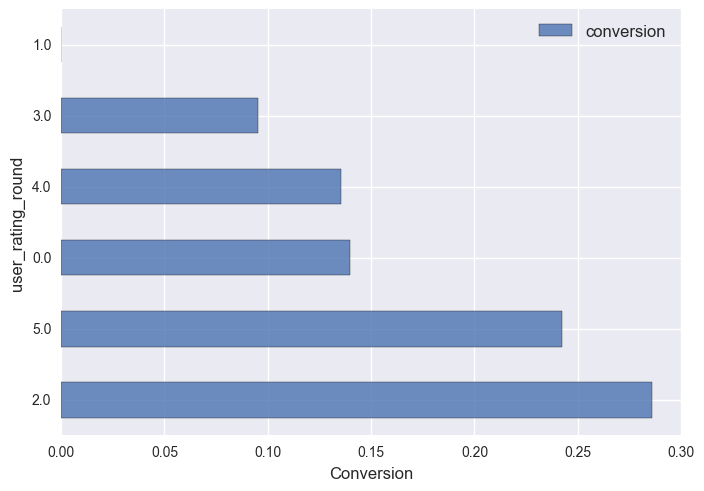

In [37]:
plot_coversion(counts_ur, 'user_rating_round')

### min_os_version  

In [86]:
data['min_os_version'][data['min_os_version'] == '7'] = '7.0'
data['min_os_version'][data['min_os_version'] == '6'] = '6.0'

/Users/amiee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/amiee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [45]:
temp_data['min_os_version'][temp_data['min_os_version'] == '6'] = '6.0'
temp_data['min_os_version'][temp_data['min_os_version'] == '7'] = '7.0'
data_install['min_os_version'][data_install['min_os_version'] == '6'] = '6.0'
data_install['min_os_version'][data_install['min_os_version'] == '7'] = '7.0'

/Users/amiee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/amiee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/amiee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/amiee/anaconda2/lib/pytho

In [46]:
counts_mov = get_conversion_table('min_os_version')
counts_mov

,min_os_version,total_counts,install_counts,conversion
3,6.0,41035,12548.0,0.305788
7,7.1.2,434,100.0,0.230415
6,7.1,2483,548.0,0.220701
9,8.0,60915,13041.0,0.214085
10,8.1,6471,1354.0,0.209241
5,7.0,153908,31553.0,0.205012
2,5.1.1,5444,1111.0,0.204078
14,9.1,51,8.0,0.156863
0,4.3,7,1.0,0.142857
13,9.0,1446,139.0,0.096127


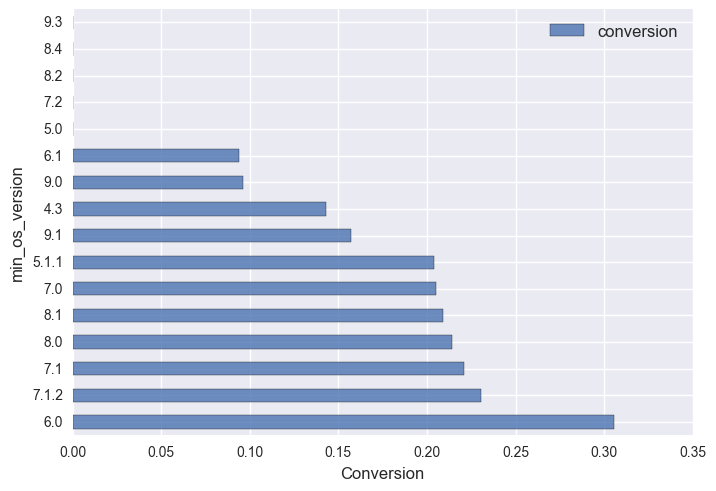

In [47]:
plot_coversion(counts_mov, 'min_os_version')

### package_name

In [53]:
counts_pn = get_conversion_table('package_name')
counts_pn.iloc[300:400,:]

,package_name,total_counts,install_counts,conversion
1483,com.taigagames.pirateislandsurvival,10,3.0,0.300000
1110,com.naquatic.guncraft,10,3.0,0.300000
314,com.bandagames.mpuzzle.gp,1517,455.0,0.299934
1665,com.williamsinteractive.jackpotparty,545,161.0,0.295413
697,com.gamehouse.hiddenartifactsgp,184,54.0,0.293478
838,com.ibotta.android,535,157.0,0.293458
490,com.djinnworks.RopeFly.lite,7,2.0,0.285714
358,com.boolit.powerlevelwarrior,7,2.0,0.285714
1055,com.minogames.minomonsters,7,2.0,0.285714
989,com.linecorp.LGPOP3,7,2.0,0.285714


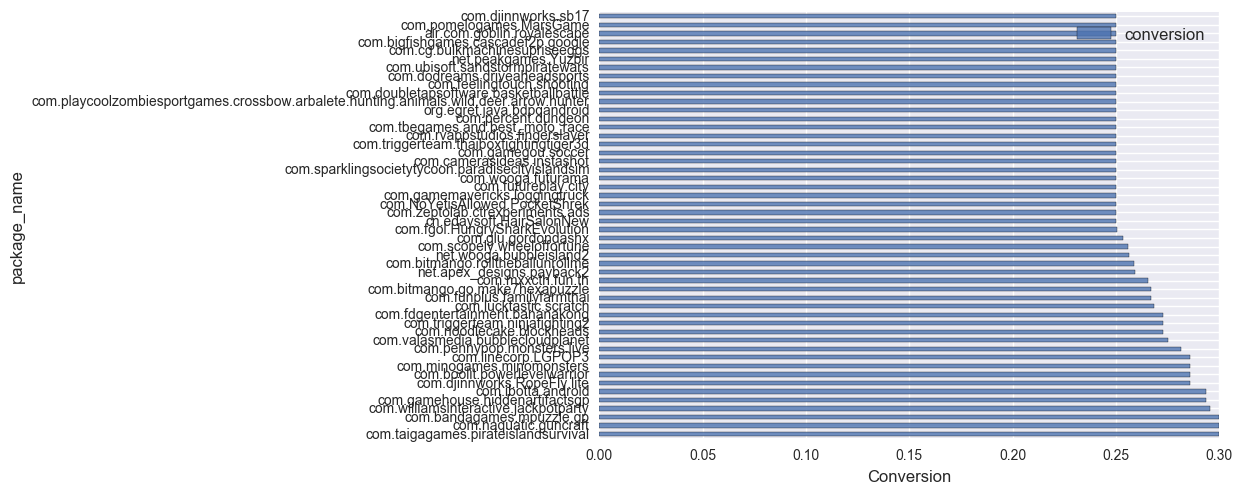

In [54]:
plot_coversion(counts_pn.iloc[300:350,:], 'package_name')

### primary_category

In [55]:
counts_pc = get_conversion_table('primary_category')
counts_pc

,primary_category,total_counts,install_counts,conversion
2,BUSINESS,6,4.0,0.666667
24,GAME_WORD,25562,11666.0,0.456381
21,GAME_SPORTS,1100,357.0,0.324545
17,GAME_PUZZLE,74771,19644.0,0.262722
28,MUSIC_AND_AUDIO,4670,1138.0,0.243683
20,GAME_SIMULATION,15557,3785.0,0.243299
9,GAME_ADVENTURE,6700,1562.0,0.233134
36,SPORTS,9,2.0,0.222222
32,PHOTOGRAPHY,9,2.0,0.222222
26,LIFESTYLE,3237,671.0,0.207291


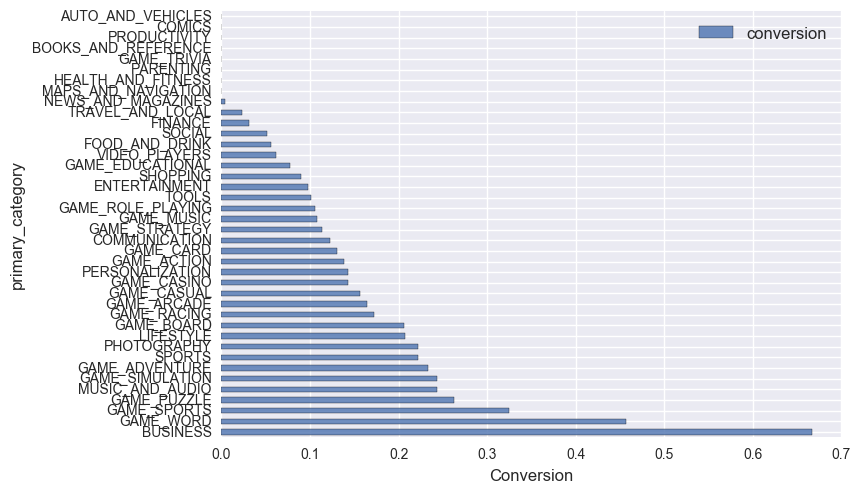

In [56]:
plot_coversion(counts_pc, 'primary_category')

### has_in_app_purchases

In [57]:
counts_iap = get_conversion_table('has_in_app_purchases')
counts_iap

,has_in_app_purchases,total_counts,install_counts,conversion
1,t,365048,69141,0.189402
0,f,46834,3064,0.065423


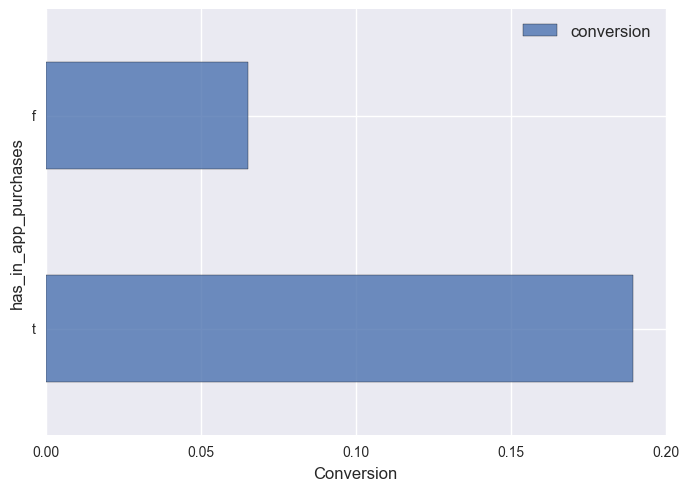

In [58]:
plot_coversion(counts_iap, 'has_in_app_purchases')

### useful features for meta:

'is_install', u'is_publisher', u'title', u'developer',
 u'content_rating', u'current_version_user_ratings', u'user_rating', u'screenshot_urls', 
 u'package_name', u'website', u'primary_category', u'has_in_app_purchases'

In [60]:
data.columns

Index([u'Unnamed: 0', u'advertiser_app_store_id', u'country_code', u'city',
       u'campaign_id', u'creative_id', u'device_language', u'device_make',
       u'device_model', u'device_platform', u'device_connection',
       u'device_os_version', u'device_screen_height', u'device_screen_width',
       u'device_volume', u'event_id', u'n_campaign_views',
       u'n_vungle_installs', u'publisher_app_store_id',
       u'time_of_last_delivery_this_campaign',
       u'time_of_last_delivery_this_creative',
       u'time_of_last_delivery_any_installed_app',
       u'time_of_last_vungle_delivery', u'time_of_this_impression',
       u'timestamp_at_install', u'time_of_this_request', u'time_zone',
       u'is_install', u'market_id', u'is_publisher', u'platform', u'title',
       u'created_at', u'last_updated_at', u'version', u'size', u'developer',
       u'developer_website', u'market_url', u'languages', u'content_rating',
       u'genre_ids', u'genres', u'current_version_user_ratings',
       u'n_

### Grouping categorical features 

In [72]:
def new_col_sig98(df, col):
    sig_level = 0.02
    df = df.copy()
    items = df[col].unique()
    for i in items:
        a = df[df[col] == i]['is_install']
        b = df[df[col] != i]['is_install']
        t, p = stats.ttest_ind(a, b, equal_var=False)
        if p >= sig_level:
            df[col][df[col] == i] = 'other'
    return df[col]

In [89]:
cols = ['advertiser_app_store_id', 'country_code', 'device_language', 'device_platform',
       'device_connection', 'time_zone_region', 'is_publisher', 'title', 'developer',
        'content_rating', 'current_version_user_ratings', 'user_rating_round', 
        'screenshot_urls', 'package_name', 'primary_category']
for col in cols:
    print col
    name = col + '_98'
    data[name] = new_col_sig98(data, col)

user_rating_round


/Users/amiee/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


content_rating
screenshot_urls
package_name
primary_category
has_in_app_purchases


In [91]:
data.columns

Index([u'Unnamed: 0', u'advertiser_app_store_id', u'country_code', u'city',
       u'campaign_id', u'creative_id', u'device_language', u'device_make',
       u'device_model', u'device_platform', u'device_connection',
       u'device_os_version', u'device_screen_height', u'device_screen_width',
       u'device_volume', u'event_id', u'n_campaign_views',
       u'n_vungle_installs', u'publisher_app_store_id',
       u'time_of_last_delivery_this_campaign',
       u'time_of_last_delivery_this_creative',
       u'time_of_last_delivery_any_installed_app',
       u'time_of_last_vungle_delivery', u'time_of_this_impression',
       u'timestamp_at_install', u'time_of_this_request', u'time_zone',
       u'is_install', u'market_id', u'is_publisher', u'platform', u'title',
       u'created_at', u'last_updated_at', u'version', u'size', u'developer',
       u'developer_website', u'market_url', u'languages', u'content_rating',
       u'genre_ids', u'genres', u'current_version_user_ratings',
       u'n_

In [92]:
data.to_csv('imbalanced_merged_grouped.csv')